In [1]:
import numpy as np 
import scipy
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import signal

import sys
from sys import path as sysapp

sysapp.append('/home/renan/IC')
sys.path.append('/usr/local/lib/python3.6/dist-packages')

from scipy import fftpack

from tikzplotlib import save as tikz_save

from scipy.fftpack import fft
saveplots = 0
import sympy as sp

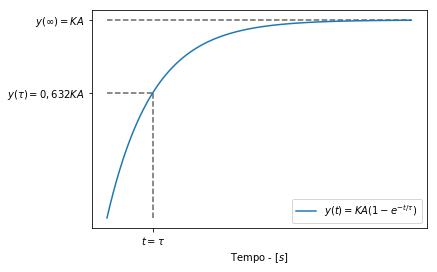

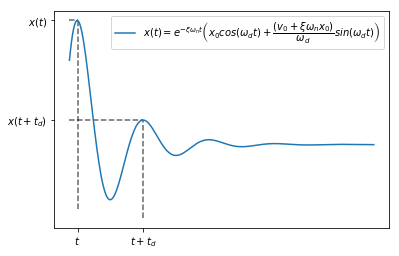

In [2]:
fig,ax = plt.subplots()

A = 1.0
tau = 0.4515
K = 12.314
t = np.linspace(0,3,100)
y = lambda t: K*A*(1-np.exp(-t/tau))
ax.plot(t,y(t),label=r'$y(t) = KA(1-e^{- t/\tau})$')

ax.hlines(max(y(t)),0,max(t),linestyle='--',alpha=0.6)
ax.hlines((y(tau)),0,tau,linestyle='--',alpha=0.6)

ax.vlines(tau,0,y(tau),linestyle='--',alpha=0.6)

ax.set_xticks([tau])
ax.set_yticks([y(tau),K*A])
ax.set_xticklabels([r'$t = \tau$'])
ax.set_yticklabels([r'$y(\tau) = 0,632KA$',r'$y(\infty)=KA$'])
ax.legend()

ax.set_xlabel(r'Tempo - $[s]$')
if saveplots:
    tikz_save("TCC/Relatorio_revisado01/Figuras/order_one_identification.tex",
            figureheight='\\figureheight',
            figurewidth='\\figurewidth'
           )
    
t = np.linspace(0,3,300)
m = 2
k = 200
c = 10

wn = (k/m)**0.5
eta = c/(2*m*wn)

wd = wn*(1-eta**2)**0.5

x0 = 0.2
v0 = 2.5


x = np.e**(-eta*wn*t)*(x0*np.cos(wd*t) + ((v0 +eta*wn*x0)/wd)*np.sin(wd*t))

fig,ax = plt.subplots()


ax.plot(t,x,label=r'$x(t)=e^{-\xi \omega_n t}\left(x_0 cos(\omega_d t) + \dfrac{(v_0 + \xi \omega_n x_0)}{\omega_d} sin(\omega_d t)\right)$')


td = 2*np.pi/wd
ax.set_xticks([t[x==max(x)][0],t[x==max(x)][0]+td])

ax.set_xticklabels([r'$t$',r'$t + t_d $'])

ax.vlines(t[x==max(x)][0],ax.get_ylim()[0],max(x),linestyle='--',alpha=0.6)
ax.vlines(t[x==max(x)][0]+td,ax.get_ylim()[0],max(x[50:]),linestyle='--',alpha=0.6)

ax.hlines(max(x[50:]),0,t[x==max(x)][0]+td,linestyle='--',alpha=0.6)
ax.hlines(max(x),0,t[x==max(x)][0],linestyle='--',alpha=0.6)

ax.set_yticks([x[x==max(x)][0],max(x[50:])])
ax.set_yticklabels([r'$x(t)$',r'$x(t+t_d)$'])

ax.legend()
if saveplots:
    tikz_save("TCC/Relatorio_revisado01/Figuras/order_two_identification.tex",
            figureheight='\\figureheight',
            figurewidth='\\figurewidth'
           )
    

In [21]:
class Shimmy_sim():
    Parameters = {
        'C_ma'   : [-2,'[-]'],
        'C_fa'   : [20,'[-]'],
        'delta'  : [0.08726646259971647,'[rad]'], #5 degree to rad
        'alpha_g': [0.17453292519943295,'[rad]'], #10 degree to rad
        'm'      : [17.65,'[kg]','Massa'],
        'a'      : [0.05,'[m]'],
        'V'      : [60,'[m/s]','Velocidade'],
        'k_psi'  : [1e5,'[N/rad]','Rigidez modo torsional'],
        'c_psi'  : [50,'[N.s/rad]','Amortecimento modo torsional'],
        'sigma'  : [0.448,'[m]'],
        'Iz'     : [0.66,'[kg.m^2]'],
        'Fz'     : [20000,'[N]'],
        'e'      : [0.3,'[m]','Trail'],
        'c_y'    : [25,'[N.s/m]','Amortecimento modo lateral'],
        'k_y'    : [1e6,'[N/m]','Rigidez modo lateral']
            }
    def __init__(self):
        self.V=self.Parameters['V'][0]
        self.a=self.Parameters['a'][0]
        self.C_ma=self.Parameters['C_ma'][0]
        self.C_fa=self.Parameters['C_fa'][0]
        self.delta=self.Parameters['delta'][0]
        self.alpha_g=self.Parameters['alpha_g'][0]
        self.sigma=self.Parameters['sigma'][0]
        self.Iz=self.Parameters['Iz'][0]
        self.Fz=self.Parameters['Fz'][0]
        self.c_psi=self.Parameters['c_psi'][0]
        self.k_psi=self.Parameters['k_psi'][0]
        self.k_y=self.Parameters['k_y'][0]
        self.c_y=self.Parameters['c_y'][0]
        self.m=self.Parameters['m'][0]
        self.e=self.Parameters['e'][0]

        self.M = np.array([[self.m,0],[0,self.Iz]])
        self.C = np.array([[self.c_y,self.e*self.c_y],[self.e*self.c_y,self.e**2*self.c_y + self.c_psi]])
        self.K = np.array([[self.k_y,self.e*self.k_y],[self.e*self.k_y,self.e**2*self.k_y + self.k_psi]])

        self.A_structural = np.zeros((2*np.shape(self.M)[0],2*np.shape(self.M)[0]))
        
        self.A_structural[:2,2:] = np.identity(np.shape(self.M)[0])
        self.A_structural[2:,:2] = -np.linalg.inv(self.M)@self.K
        self.A_structural[2:,2:] = -np.linalg.inv(self.M)@self.C
        
        

        self.A_shimmy = np.array([[-self.c_y/self.m,-self.c_y*self.e/self.m,-self.k_y/self.m,-self.k_y*self.e/self.m,self.C_fa*self.Fz/self.m],
                     [-self.c_y*self.e/self.Iz,-(self.c_y*self.e**2+self.c_psi)/self.Iz,-self.k_y*self.e/self.Iz,-(self.k_y**self.e+self.k_psi)/self.Iz,self.C_ma*self.Fz/self.Iz],
                     [1,0,0,0,0],
                     [0,1,0,0,0],
                     [-1/self.sigma,-self.a/self.sigma,0,self.V/self.sigma,-self.V/self.sigma]])
Sim = Shimmy_sim()       
A_struc = Sim.A_structural
A_shimmy = Sim.A_shimmy

s, v = np.linalg.eig(A_struc)
t,h = np.linspace(0,0.5,1000,retstep=True)

x = lambda t: c1*np.exp(s[0]*t)*v[:,0] + c2*np.exp(s[1]*t)*v[:,1] + c3*np.exp(s[2]*t)*v[:,2] + c4*np.exp(s[3]*t)*v[:,3]

np.random.seed(11)
number_of_realizations =2
number_of_sensors=2

x_0 = 10*np.random.rand(number_of_realizations,4)

inv_v = np.linalg.inv(v)

C_c = np.zeros((number_of_sensors,np.shape(x_0)[1]))
C_c[0,:] = [1,0,0,0]  
C_c[1,:] = [0,1,0,0]  




x_big_array = np.zeros((number_of_realizations,np.shape(t)[0],number_of_sensors))
for experiment in range(0,np.shape(x_0)[0]):
    print(f'Experimento {experiment}')
    c = inv_v@x_0[experiment,:]
    c1,c2,c3,c4 = c
    x_big_array[experiment] = np.array([C_c@x(t) for t in t]).real


Experimento 0
Experimento 1


In [12]:
def Hankel_free(Y,r,s):
    q,k,p = np.shape(Y)
    H = np.zeros((r*p,q*s))
    H_star = np.zeros_like(H)
    

    for rows in range(0,r):
        for cols in range(0,s):
            for _q in range(0,q):
                
                #print(Y[_q][rows+cols,:]) #array de ordem igual a `p` sensores

                
                H[rows*p:(rows+1)*p,cols*q+_q] = Y[_q][rows+cols,:]
                H_star[rows*p:(rows+1)*p,cols*q+_q] = Y[_q][rows+cols+1,:]
    return H,H_star

def Free_response_experiment(t,y,r,s,epsilon=1e-4):
    #y deve ter shape o formato a = [q][k,p]
    #indice q representa a experimentacao q;
    #indice k representa o instante discreto da amostra;
    #indica p representa o numero de sensores; 
        p,q = np.shape(y)[2],np.shape(y)[0]
        H,H_star = Hankel_free(y,r,s)
        
        input_number = q
        output_number = p
        
        P,D_vector,Qh = np.linalg.svd(H,full_matrices=False) 
        D = np.diag(D_vector)
        Q = Qh.conj().T
    
        P_d = P@D
        n_orders = [D_vector>=epsilon][0]
    
        P_tilde = P[:,n_orders]
        D_tilde = np.diag(D[n_orders])
        Q_tilde = Q[:,n_orders]
        P_d_tilde = P_d[:,n_orders]

        D_tilde_half_neg = np.diag(D_vector[n_orders]**-0.5)
        D_tilde_half_pos = np.diag(D_vector[n_orders]**0.5)

        A_id = (D_tilde_half_neg @ P_tilde.T) @ H_star @ (Q_tilde @D_tilde_half_neg)

        E_m = (np.eye(input_number,M=np.shape(Q_tilde)[0])).T
        E_p = np.eye(output_number,M=np.shape(P_tilde)[0]).T


        B_id = D_tilde_half_pos@Q_tilde.T@E_m
        C_id = E_p.T@P_tilde@D_tilde_half_pos
        
        
        
        Matrice_acumulada  = np.eye(N=np.shape(A_id)[0],M=np.shape(A_id)[1])
        
        Reconstructed_states = np.zeros((q,len(t),p))
        
        lambdas,psi = np.linalg.eig(A_id)
        A_d = np.diag(lambdas)
        B_d = np.linalg.inv(psi)@B_id
        C_d = C_id@psi
        
        k =np.arange(0,len(t))
        for _k in k:
            
            for _q in range(0,q):
                (Reconstructed_states[_q][_k,:]) = ((C_id@Matrice_acumulada@B_id)[:,_q])
                
            Matrice_acumulada=Matrice_acumulada@A_id

        
        return  {'A_id':A_id,
                 'B_id': B_id,
                 'C_id': C_id,
                 'Reconstructed_states':Reconstructed_states,
                 'A_d':A_d,
                 'B_d':B_d,
                 'C_d':C_d,
                 'phi':psi,
                 'lambda_i':lambdas,
                 'P':P,
                  'D':D,
                  'Qh':Qh,
                }

def modal_parameters(eigenvalue):
    omega_i = (eigenvalue.real**2  + eigenvalue.imag**2)**0.5
    zeta_i = -eigenvalue.real/omega_i
    return omega_i,zeta_i


r = 20
s = 20

Simulation = Free_response_experiment(t,x_big_array,r,s) #Transforma uma unica realizacao em um experimento;
A_id = (Simulation['A_id'])
B_id = (Simulation['B_id'])
C_id = (Simulation['C_id'])
A_d = (Simulation['A_d'])
B_d = (Simulation['B_d'])
C_d = (Simulation['C_d'])
Reconstructed_states= (Simulation['Reconstructed_states'])
phi = (Simulation['phi'])
lambda_i = (Simulation['lambda_i'])


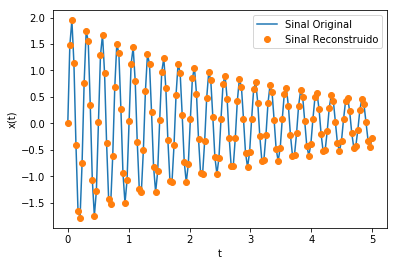

In [5]:
t,T = np.linspace(0,5,150,retstep=True)
eta = 0.3
x = np.zeros((1,len(t),1))
x[0][:,0]  = 2*np.exp(-eta*t)*np.sin(25*t)
ERA = Free_response_experiment(t,x,5,5)

Reconstructed_states= ERA['Reconstructed_states']

Reconstructed_states[:,0:10,0],x[:,0:10,0]

fig,ax = plt.subplots()
ax.plot(t,x[0,:,0],label='Sinal Original')
ax.plot(t,Reconstructed_states[0,:,0],label='Sinal Reconstruido',linestyle=' ',marker='o')
ax.set_xlabel('t')
ax.set_ylabel('x(t)')
ax.legend()
if saveplots:
    tikz_save(f"TCC/Relatorio_revisado01/Figuras/AppendixExample.tex",
                    figureheight='\\figureheight',
                    figurewidth='\\figurewidth'
                   )

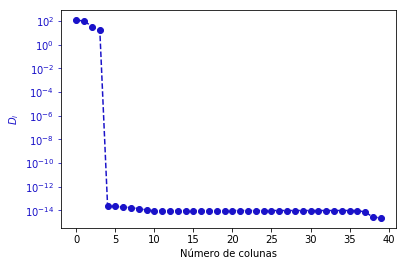

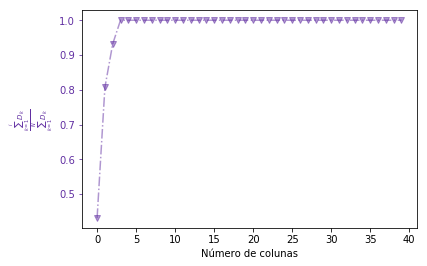

In [13]:
D = Simulation['D']

fig,ax = plt.subplots()




ax.plot(D.diagonal(),linestyle='--',marker='o',color='#1a12c9')
ax.yaxis.label.set_color('#1a12c9')
ax.tick_params(axis='y', colors='#1a12c9')

ax.set_xlabel('Número de colunas')
ax.set_ylabel('$D_i$ ')
ax.set_yscale('log')

if saveplots:
    tikz_save(f"TCC/Relatorio_revisado01/Figuras/SVD.tex",
                    figureheight='\\figureheight',
                    figurewidth='\\figurewidth'
                   )

fig,ax2 = plt.subplots()
ax2.plot(np.cumsum(D.diagonal()/np.sum(D.diagonal())),color='#612fa2',marker='v',linestyle='-.',alpha=0.5)
ax2.yaxis.label.set_color('#612fa2')
ax2.tick_params(axis='y', colors='#612fa2')
ax2.set_ylabel(r'$\frac{\sum_{k=1}^{i} D_k}{\sum_{k=1}^{N} D_k}$')
ax2.set_xlabel('Número de colunas')
if saveplots:
    tikz_save(f"TCC/Relatorio_revisado01/Figuras/SVD2.tex",
                    figureheight='\\figureheight',
                    figurewidth='\\figurewidth'
                   )

In [14]:
def MAC(psi_a, psi_b):
    #enviar vetor numpy com shape (i,)
    _psi_a = psi_a[:,None] #Ajuste do shape
    _psi_b = psi_b[:,None]
    MAC = (_psi_a.conj().T@_psi_b@_psi_b.conj().T@_psi_a)/(_psi_a.conj().T@_psi_a@_psi_b.conj().T@_psi_b)
    return MAC

def MAC_Matrix(modal_m_1,modal_m_2 = None):
    try:
        if modal_m_2 == None:
            modal_m_2 = modal_m_1 #AutoMAC
    except:
        pass
    MAC_m = np.zeros((np.shape(modal_m_1)[1],np.shape(modal_m_2)[1]))

    for i in range(0,np.shape(modal_m_1)[1]):
        for j in range(0,np.shape(modal_m_2)[1]):
            MAC_m[i,j] = ((MAC(modal_m_1[:,i],modal_m_2[:,j])).real[0,0])

    return MAC_m

In [15]:

if  saveplots:
    
    colors = ['#6948dd', '#d01c18','#f02c78','#d0acf8','#107ca8','#6948dd', '#f07c78','#f02c78','#d0acf8','#107ca8']
    for estado in [0,1]: #qual sensor esta sendo medido
            
        for _q in range(0,np.shape(x_big_array)[0]): #Varre os experimentos
            fig,ax = plt.subplots()

            ax.plot(t,Reconstructed_states[_q][:,estado].real,alpha = 0.5,color=colors[_q], linestyle = ' ',marker='o',markersize=5,label=f' Ensaio {_q+1}')
            ax.plot(t,x_big_array[_q][:,estado].real,alpha =1,color=colors[_q])
            ax.set_xlabel(r'$tempo\ -\ [s]$')
            ax.set_ylabel(r'${{{\bar{Y}}}}_d[k]({%i,:})$'%(estado+1))
            ax.legend()


            tikz_save(f"TCC/Relatorio_revisado01/Figuras/system_id_state{estado}_{_q}.tex",
                    figureheight='\\figureheight',
                    figurewidth='\\figurewidth'
                   )


In [25]:
x_big_array.shape

(2, 1000, 2)

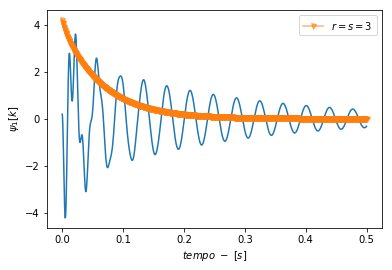

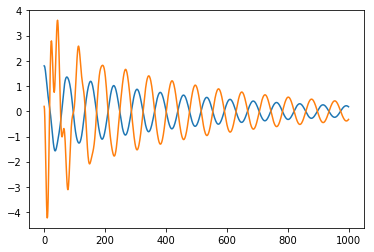

In [51]:

markers=['v','o','x','^']

for cont,_r in enumerate([3]):
    r = _r
    s = 1
    Simulation = Free_response_experiment(t,x_big_array,r,s) #Transforma uma unica realizacao em um experimento;

    Reconstructed_states= (Simulation['Reconstructed_states'])
    phi = (Simulation['phi'])
    lambda_i = (Simulation['lambda_i'])

    fig,ax=plt.subplots()
    for _q in [0]:
        ax.plot(t, x_big_array[0,:, 1])
        ax.plot(t,Reconstructed_states[1,:,_q],alpha=0.6,marker=markers[cont],label=rf'$r=s=%d$'%r,markersize=5)
        ax.legend()
        ax.set_xlabel(r'$tempo\ -\ [s]$')
        ax.set_ylabel(r'$\psi_1[k]$')
        if saveplots:
            tikz_save(f"TCC/Relatorio_revisado01/Figuras/system_order_{_q}.tex",
                            figureheight='\\figureheight',
                            figurewidth='\\figurewidth'
                           )
fig, ax = plt.subplots()
for _q in [0, 1]:
    with open(f'DadosZ{_q}.txt','w+') as file:
        ax.plot(x_big_array[0, :, _q])
        np.savetxt(file, x_big_array[0, :, _q])
    with open(f'DadosIdZ{_q}.txt', 'w+') as file:
        np.savetxt(file, Reconstructed_states[0, :, _q])
    

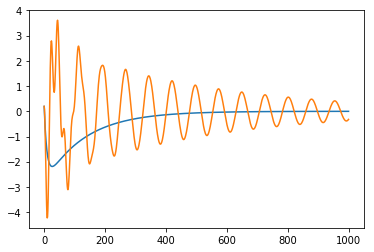

In [41]:
_q = 1
plt.plot(Reconstructed_states[0,:,_q])
plt.plot(x_big_array[0, :, _q])

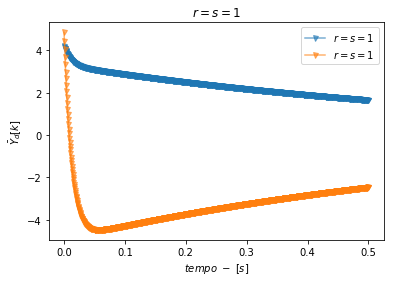

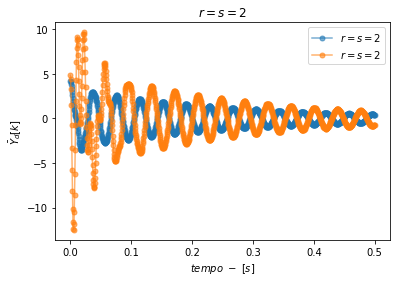

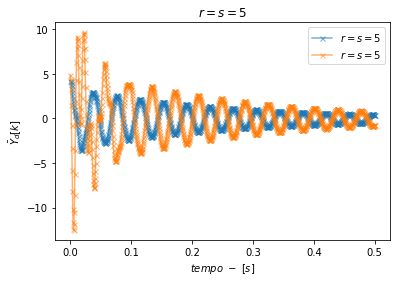

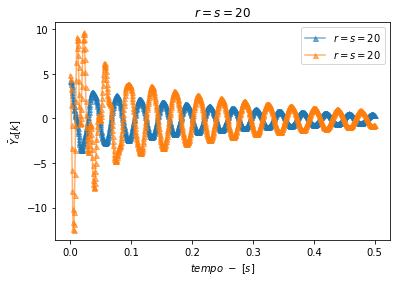

In [22]:

markers=['v','o','x','^']

for cont,_r in enumerate([1,2,5,20]):
    r = s = _r

    Simulation = Free_response_experiment(t,x_big_array,r,s) #Transforma uma unica realizacao em um experimento;

    Reconstructed_states= (Simulation['Reconstructed_states'])
    phi = (Simulation['phi'])
    lambda_i = (Simulation['lambda_i'])

    fig,ax=plt.subplots()
    for _q in [0,1]:
        
        ax.plot(t,Reconstructed_states[1,:,_q],alpha=0.6,marker=markers[cont],label=r'$r=s=%d$'%r,markersize=5)
        ax.set
        ax.legend()
        ax.set_xlabel(r'$tempo\ -\ [s]$')
        ax.set_ylabel(r'${{{\bar{Y}}}}_d[k]$')
        ax.set_title(r'$r=s=%d$'%r)
        if saveplots:
            tikz_save(f"TCC/Relatorio_revisado01/Figuras/system_order_{_q}.tex",
                            figureheight='\\figureheight',
                            figurewidth='\\figurewidth'
                           )

In [17]:
Simulation

{'A_id': array([[ 0.98298971, -0.20831195,  0.06342463,  0.01001757],
        [ 0.21654305,  0.9215352 ,  0.01116359,  0.07769137],
        [-0.07753214,  0.04954193,  1.11387091, -0.12728252],
        [-0.02562346, -0.08886144,  0.32189123,  0.85770095]]),
 'B_id': array([[-0.67995817, -1.41730563],
        [ 0.89789   ,  2.98478315],
        [-0.15889555, -1.16955858],
        [ 1.17135997,  2.00261568]]),
 'C_id': array([[-0.92242802, -0.04055651, -1.05111775,  0.89202448],
        [ 1.02222852,  3.27734308, -0.03409021, -1.75717573]]),
 'Reconstructed_states': array([[[ 1.80269689e+00,  1.94752415e-01],
         [ 1.79186379e+00,  9.07935601e-02],
         [ 1.75537549e+00, -2.13968292e-01],
         [ 1.69509036e+00, -6.86135244e-01],
         [ 1.61390118e+00, -1.27922472e+00],
         [ 1.51549482e+00, -1.93776877e+00],
         [ 1.40406396e+00, -2.60197172e+00],
         [ 1.28399433e+00, -3.21254514e+00],
         [ 1.15955271e+00, -3.71533891e+00],
         [ 1.03459928e+00

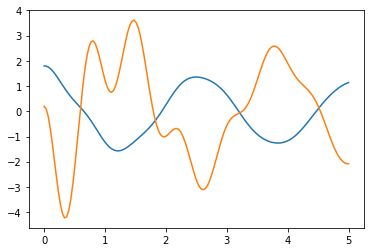

In [18]:
fig, ax = plt.subplots()
ax.plot(t, Simulation['Reconstructed_states'][0])



In [19]:
A_id= Simulation['A_id']

In [20]:
z = np.linalg.eigvals(A_id)
z

array([0.94343425+0.27251549j, 0.94343425-0.27251549j,
       0.99461413+0.08208303j, 0.99461413-0.08208303j])

In [41]:
np.log(z[0])/t[1]

(-36.282414925056955+561.8390289795628j)

In [46]:
Simulation['C_id']@Simulation['phi']

array([[-0.07539217-0.12015588j, -0.07539217+0.12015588j,
        -0.57258937+0.40528719j, -0.57258937-0.40528719j],
       [-0.88938454-1.98863305j, -0.88938454+1.98863305j,
         0.96833254-0.74648114j,  0.96833254+0.74648114j]])